In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import cv2
import os
from matplotlib import pyplot as plt
import random
print(os.listdir("../input"))
train_images_list = os.listdir('../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/')
sample_size = 30
train_images_list = train_images_list[:sample_size]
#print (train_images_list)
# Any results you write to the current directory are saved as output.

['checkpoint-copy', 'image-copy', 'flickr-image-dataset', 'dataset-flickr30k']


50
9848
True
True
True
['two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard']


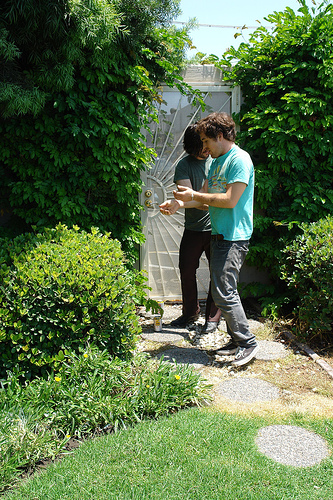

In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
# each image id has 5 captions
from PIL import Image
import json
#Load Karpathy's Split. 
with open('../input/dataset-flickr30k/dataset_flickr30k.json', 'r') as j:       
    data = json.load(j)

#Define the lists to store the images paths and the captions of the image
train_image_paths = []
train_image_captions = []
val_image_paths = []
val_image_captions = []
test_image_paths = []
test_image_captions = []
word_freq = Counter()

captions_per_image=5
min_word_freq=2
max_len=50

for img in data['images']:                     
    captions = []                             
    for c in img['sentences']:                
        word_freq.update(c['tokens'])
        current_token=c['tokens']
        if len(current_token) > max_len:        
            continue

        captions.append(current_token)      
    path = os.path.join('../input/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/', img['filename'])    

    if img['split'] in {'train', 'restval'}:        
        for caption in captions:
            train_image_paths.append(path)      
            train_image_captions.append(caption)    

    elif img['split'] in {'val'}:
        for caption in captions:
            val_image_paths.append(path)
            val_image_captions.append(caption)

    elif img['split'] in {'test'}:
        for caption in captions:
            test_image_paths.append(path)
            test_image_captions.append(caption)
        



 # Create word map

words = [w for w in word_freq.keys()  if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

print (max_len)
print (len(word_map))
print (len(train_image_captions)==len(train_image_paths))
print (len(test_image_captions)==len(test_image_paths))
print (len(val_image_captions)==len(val_image_paths))
print (train_image_captions[0])
Image.open(train_image_paths[0])



In [3]:
## Trying to use Dataloader of Pytorch
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

class Flickr30kDataset(Dataset):
    """Flickr30k dataset."""

    def __init__(self, img_paths,img_captions, transform=None):
        """
        Args:
            img_paths : list of paths
            img_captions : list of captions
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_paths = img_paths
        self.img_captions = img_captions
        self.transform = transform

    def __len__(self):
        return len(self.img_captions)

    def __getitem__(self, idx):
        
        img_name = self.img_paths[idx] 
        
        #print ('img_name '+img_name)
        #image = io.imread(img_name) #gives numpy image , use this if overiding transforms classes
        image = Image.open(img_name)
        caption=self.img_captions[idx]
        
        cap_len=[]
        enc_captions=[]
        
        cap_len.append(len(caption)+2)  # 2 for <start> and <end> 
        enc_caption=[word_map['<start>']]+[word_map.get(word, word_map['<unk>']) for word in caption]+[word_map['<end>']]+(max_len-len(caption))*[word_map['<pad>']]
        enc_captions.append(enc_caption)
        if self.transform:
            image = self.transform(image)
            #imshow(image)
            #print (caption)
        
        enc_captions=np.asanyarray(enc_captions)
        captions = torch.from_numpy(enc_captions)
        cap_len=torch.LongTensor([cap_len])
        sample = {'image': image, 'captions': captions,'cap_len':cap_len}
        return sample



# currently I have not used numpy image , no overiding
transformed_dataset = Flickr30kDataset(train_image_paths,train_image_captions,
                                           transform=transforms.Compose([
                                               transforms.Resize((256,256)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                                           ]))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

'''
for i in range(3):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['captions'].size())
    imshow(sample['image'])
    print (sample['captions'])

'''
dataloader = DataLoader(transformed_dataset ,batch_size=4,
                        shuffle=True, num_workers=4)


for i_batch, sample_batched in enumerate(dataloader):
    if (i_batch==3):
        break
    print(i_batch, sample_batched['image'].size(),
          sample_batched['captions'].size(), sample_batched['cap_len'].size())

0 torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 52]) torch.Size([4, 1, 1])
1 torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 52]) torch.Size([4, 1, 1])
2 torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 52]) torch.Size([4, 1, 1])


In [4]:
#Models 

#Encoder - CNN , pretrained ,using Resnet101
import torch
from torch import nn
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))


    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)  image_size : orignally is 256
        :return: encoded images
        """
        out = self.resnet(images)  
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out


In [5]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim):
        """
        :param encoder_dim: feature size of encoded images = 2048
        :param decoder_dim: size of decoder's RNN 
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, decoder_dim)  # linear layer to transform encoded image
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        #print (encoder_out.size())
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, decoder_dim)
        decoder_hidden_copy=decoder_hidden.unsqueeze(2)  #(batch_size, decoder_dim,1)
        score = torch.bmm(att1,decoder_hidden_copy)  # (batch_size , num_pixels ,1)
        
        score = score.squeeze(2) # (batch_size , num_pixels)
        
        alpha = self.softmax(score)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [6]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """
        # encoder_out is (N,encode_dim,encode_dim,2048)
        # N =batch_size
        # encode_dim = 2048

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        # num_pixels = 14*14 = 196
        num_pixels = encoder_out.size(1)
        caption_lengths = caption_lengths.squeeze(2)
        #print (caption_lengths)
        #print (encoder_out.size())
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        #print (encoder_out.size())
        #print (sort_ind)
        #print (encoded_captions)
        encoder_out = encoder_out[sort_ind]
        #print (encoder_out.size())
        encoded_captions = encoded_captions.squeeze(1)
        #print (encoded_captions)
        #print (encoded_captions.size())
        
        encoded_captions = encoded_captions[sort_ind]
        #print (encoded_captions)
        #print (encoded_captions.size())
        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        #print (embeddings.size())
        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # DO this -1 as <end> token is never an input to LSTMCell
        decode_lengths = (caption_lengths - 1).tolist()
        #print (caption_lengths)
        #print (decode_lengths)
        
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        
        
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            #print ("BEFORE GATE")
            #print (attention_weighted_encoding.size())
            attention_weighted_encoding = gate * attention_weighted_encoding
            #print ("AFTER GATE")
            #print (embeddings.size())
            #print (attention_weighted_encoding.size())
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind

In [7]:
model_parameters = filter(lambda p:p.requires_grad ,DecoderWithAttention(512,512,9848,2048,0.1).parameters() )
params = sum([np.prod(p.size()) for p in model_parameters])
print (params)
print (DecoderWithAttention(512,512,9848,2048,0.1))

20587640
DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (softmax): Softmax()
  )
  (embedding): Embedding(9848, 512)
  (dropout): Dropout(p=0.1)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=9848, bias=True)
)


In [8]:
# Training

import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence

# Model parameters
emb_dim = 512  # dimension of word embeddings
decoder_dim = 512  # dimension of decoder RNN
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
# Training parameters
start_epoch = 0
epochs = 120  
epochs_since_improvement = 0  
batch_size = 32
workers = 1  
decoder_lr = 4e-4   
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper

checkpoint = '../input/checkpoint-copy/checkpoint_copy.pt' #None # path to checkpoint, None if none
data_name='4'

rev_word_map = {v: k for k, v in word_map.items()} # ix2word
def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder,  decoder_optimizer):
    state = {'decoder_state_dict': decoder.state_dict(),
             'decoder_optimizer_dict': decoder_optimizer.state_dict()}
    filename = 'checkpoint_copy.pt'
    print (filename)
    torch.save(state, filename)

def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """
    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))    
    

def train(train_loader, encoder, decoder, criterion, decoder_optimizer, epoch , start ):
    decoder.train()  
    encoder.train()
    
    for i, sample in enumerate(train_loader):
        current_time = time.time()
        if (current_time-start >= 6*3600):
            break
        imgs = sample['image']
        caps = sample['captions']
        caplens = sample['cap_len']
         
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)
        
        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        #print (caps_sorted)
        targets = caps_sorted[:, 1:]
        #print (targets)
        #print (scores[0])
        if (epoch%8==0):
            with torch.no_grad():
                ans=[]
                for t in range(max(decode_lengths)):
                    #print (scores.size())
                    data = scores[0,t,:]
                    
                    data = F.softmax(data, dim=0)
                    #print (data.size())
                    val = (max(data))
                    for j in range(len(word_map)):
                        if data[j]==val:
                            ans.append(rev_word_map[j])
                            break
                    
                Ans=[]
                print (scores.size())
                print (targets.size())
                for j in (targets[0]):
                    #print (j.data.tolist())
                    Ans.append(rev_word_map[j.data.tolist()])
                print (ans)
                print (Ans)
        # Remove timesteps that we didn't decode at, or are pads
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)
        #print (scores.size())
        #print (targets.size())
        
        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
        
        if (epoch%8==0):
            print (loss)
        # Back prop.
        decoder_optimizer.zero_grad()
        loss.backward()

        
        # Update weights
        decoder_optimizer.step()
        

def main():
    global epochs_since_improvement, checkpoint, start_epoch, data_name, word_map
    
    
    decoder = DecoderWithAttention(embed_dim=emb_dim,
                                   decoder_dim=decoder_dim,
                                   vocab_size=len(word_map),
                                   dropout=dropout)
    #print (decoder)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=decoder_lr)
    encoder = Encoder()
    # Move to GPU, if available
    decoder = decoder.to(device)
    encoder = encoder.to(device)
    if checkpoint is not None:
        checkpoint = torch.load(checkpoint)
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_dict'])
    

    # Loss function
    criterion = nn.CrossEntropyLoss().to(device)
    transformed_dataset = Flickr30kDataset(train_image_paths[:9000],train_image_captions[:9000],
                                           transform=transforms.Compose([
                                               transforms.Resize((256,256)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
                                           ]))
    dataloader = DataLoader(transformed_dataset ,batch_size=batch_size,
                        shuffle=True, num_workers=workers, pin_memory=True)
    start = time.time()
    for epoch in range(start_epoch, epochs):
        
            
        current_time = time.time()
        if (current_time-start >= 6*3600):
            print ("2 minutes completed ")
            print (epoch)
            break
        train(dataloader, encoder, decoder, criterion, decoder_optimizer, epoch ,start)
    
    print ("EPOCHS COMPLETED")
    save_checkpoint(data_name, 0, epochs_since_improvement, encoder, decoder, decoder_optimizer)
        
#main()


cuda


In [9]:

rev_word_map = {v: k for k, v in word_map.items()} # ix2word

decoder = DecoderWithAttention(embed_dim=emb_dim,
                                   decoder_dim=decoder_dim,
                                   vocab_size=len(word_map),
                                   dropout=dropout)
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                     lr=decoder_lr)
encoder = Encoder()
# Move to GPU, if available
decoder = decoder.to(device)
encoder = encoder.to(device)
if checkpoint is not None:
        checkpoint = torch.load(checkpoint)
        decoder.load_state_dict(checkpoint['decoder_state_dict'])
        decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_dict'])
    



Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:12, 14113853.16it/s]


In [10]:

decoder.eval()
encoder.eval()
from scipy.misc import imread, imresize

def predict_output(image):  #give path name
    sampled = []
    transform=transforms.Compose([transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
                                           ])
    image = transform(Image.open(image))  # (3, 256, 256)
    #imshow(image)
    #print (image.size()) #(3,256,256)
    image = image.unsqueeze(0) #(1,3,256,256)
    image = torch.FloatTensor(image).to(device)
    enc_image = encoder(image)
    enc_image = enc_image.view(1, -1, 2048)
    #print (enc_image.size())
    h,c = decoder.init_hidden_state(enc_image) 
    pred = torch.LongTensor([[word_map['<start>']]]).to(device)
    #print (pred.size())
    ans=[]
    for t in range(50):
        
        embeddings = decoder.embedding(pred).squeeze(1)  
        attention_weighted_encoding, alpha = decoder.attention(enc_image,h)
        gate = decoder.sigmoid(decoder.f_beta(h))  
        #print ("BEFORE GATE")
        #print (attention_weighted_encoding.size())
        attention_weighted_encoding = gate * attention_weighted_encoding
        #print ("AFTER GATE")
        #print (embeddings.size())
        #print (attention_weighted_encoding.size())
        h, c = decoder.decode_step(
            torch.cat([embeddings, attention_weighted_encoding], dim=1),(h, c))  # (batch_size_t, decoder_dim)
        pt = decoder.fc(decoder.dropout(h))  # (batch_size_t, vocab_size)
        #print (pt.size())
        _,pred = pt.max(1)
        
        data = F.softmax(pt.squeeze(0), dim=0)
        
        
        #print (pred)
        
        n = len(ans)
        if (pred.item() == word_map['<end>']):
            break
        ans.append(pred.item())
        sampled.append(pred.item())
        
    generated_words = [rev_word_map[sampled[i]] for i in range(len(sampled))]
    #print (ans)
    #print (generated_words)
    return generated_words
'''
for i in range(9500,9600,5):
    print (predict_output(train_image_paths[i]))
'''
list_of_references = []
ref=[]
hyp=[]
for i in range(len(test_image_captions)):
    if (i==0):
        ref=[]
    elif (i!=0 and test_image_paths[i]!=test_image_paths[i-1]):
        list_of_references.append(ref)
        ref=[]
    ref.append(test_image_captions[i])
    #print (val_image_captions[i])
    HP=predict_output(test_image_paths[i])
    if (i==0):
        hyp.append(HP)
    elif (i!=0 and HP!=hyp[-1]):
        hyp.append(HP)
list_of_references.append(ref)

#print (val_image_captions[50])
#print (list_of_references)
#print (hyp)


In [11]:
from nltk.translate.bleu_score import corpus_bleu
print (corpus_bleu(list_of_references,hyp))
print (len(list_of_references))

0.09447360322969989
1000
